In [1]:
import os
import numpy as np
from PIL import Image
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
from pathlib import Path
from collections import Counter
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

### KNN initialization

In [2]:
class KNN:
    def __init__(self, k=5, device=None):
        self.k = k
        self.train_data = None
        self.train_labels = None
        self.device = device if device else torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def fit(self, X, y):
        if not isinstance(X, torch.Tensor):
            X = torch.tensor(X, dtype=torch.float32, device=self.device)
        if not isinstance(y, torch.Tensor):
            y = torch.tensor(y, dtype=torch.long, device=self.device)
        self.train_data = X
        self.train_labels = y

    def predict(self, X, batch_size=32):
        if not isinstance(X, torch.Tensor):
            X = torch.tensor(X, dtype=torch.float32, device=self.device)
        predictions = []
        for i in range(0, X.size(0), batch_size):
            batch = X[i:i+batch_size]
            distances = torch.cdist(batch, self.train_data)
            k_indices = distances.topk(self.k, largest=False, dim=1).indices
            k_labels = self.train_labels[k_indices]
            batch_predictions = torch.mode(k_labels, dim=1).values
            predictions.append(batch_predictions)
        return torch.cat(predictions, dim=0)

    def evaluate(self, X, y):
        if not isinstance(X, torch.Tensor):
            X = torch.tensor(X, dtype=torch.float32, device=self.device)
        if not isinstance(y, torch.Tensor):
            y = torch.tensor(y, dtype=torch.long, device=self.device)
        with torch.no_grad():
            predictions = self.predict(X)
            accuracy = (predictions == y).float().mean().item()
        return accuracy




def preprocess_data(train_data, val_data, test_data):

    scaler = StandardScaler()
    train_scaled = scaler.fit_transform(train_data)
    val_scaled = scaler.transform(val_data)
    test_scaled = scaler.transform(test_data)
    return train_scaled, val_scaled, test_scaled


### Loading the PCA data and training

--------------------------------------------------
K = 1
Training Accuracy: 99.97%
Validation Accuracy: 87.79%
Test Accuracy: 88.04%
--------------------------------------------------
K = 2
Training Accuracy: 95.03%
Validation Accuracy: 84.03%
Test Accuracy: 84.33%
--------------------------------------------------
K = 3
Training Accuracy: 92.98%
Validation Accuracy: 84.03%
Test Accuracy: 85.14%
--------------------------------------------------
K = 4
Training Accuracy: 91.47%
Validation Accuracy: 83.09%
Test Accuracy: 83.86%
--------------------------------------------------
K = 5
Training Accuracy: 90.11%
Validation Accuracy: 84.84%
Test Accuracy: 85.14%
--------------------------------------------------
K = 6
Training Accuracy: 88.20%
Validation Accuracy: 83.77%
Test Accuracy: 84.59%
--------------------------------------------------
K = 7
Training Accuracy: 88.58%
Validation Accuracy: 83.65%
Test Accuracy: 84.20%
--------------------------------------------------
K = 8
Training Acc

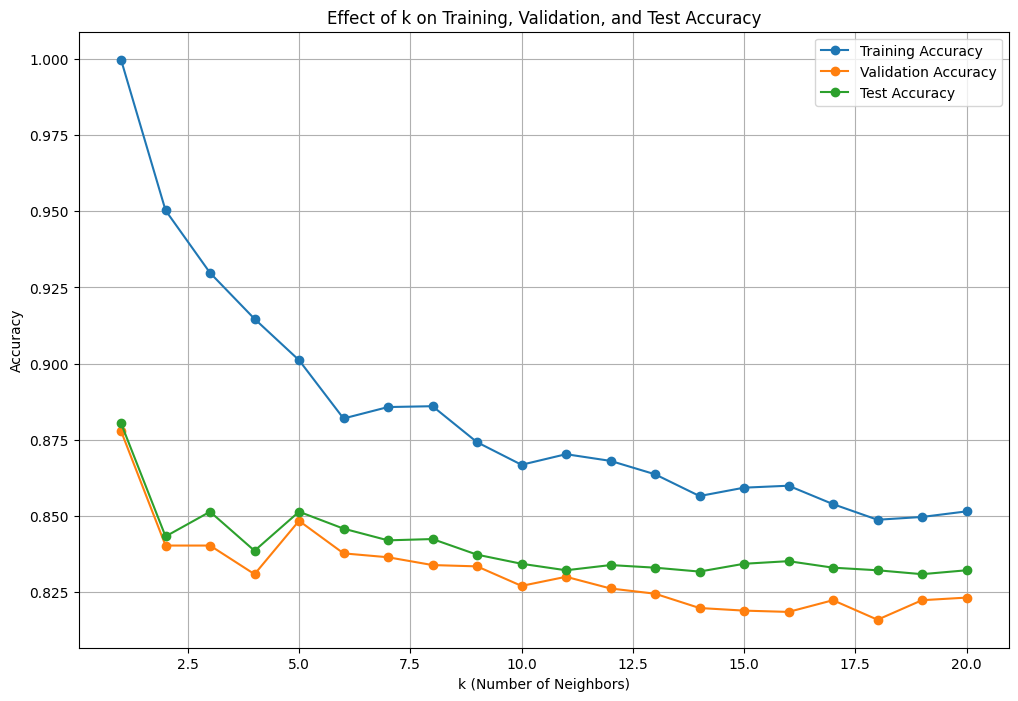

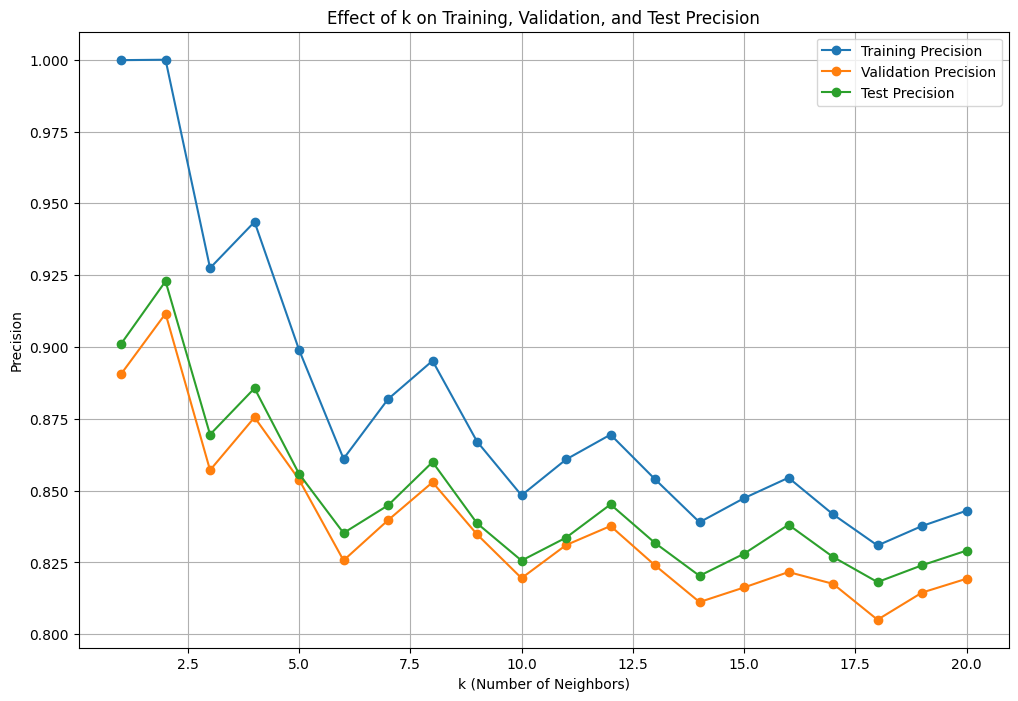

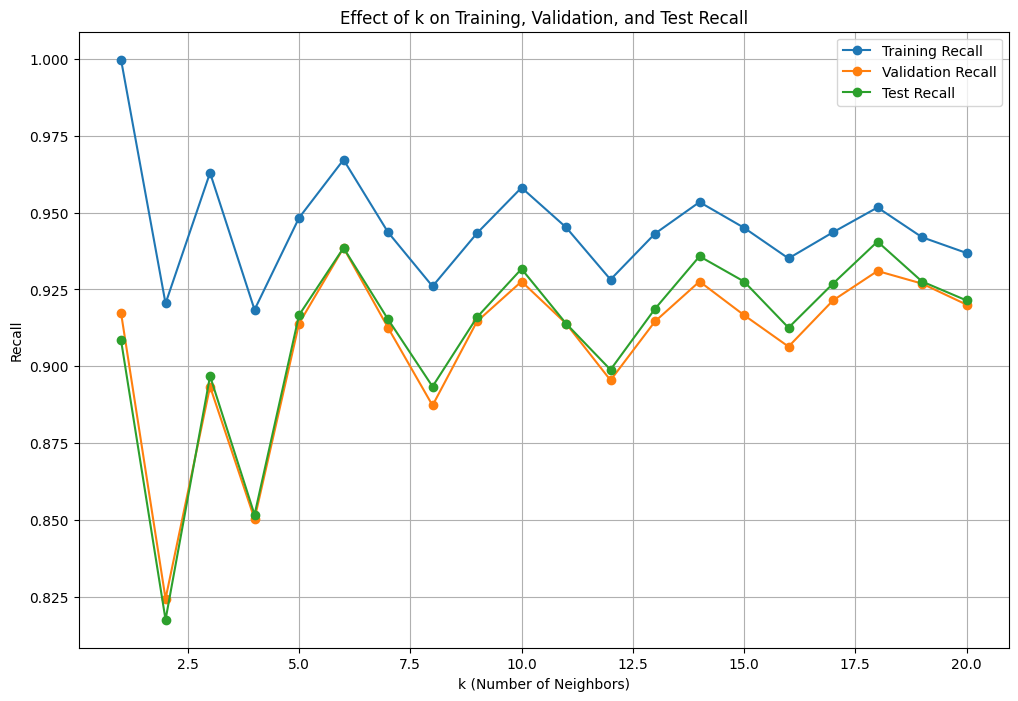

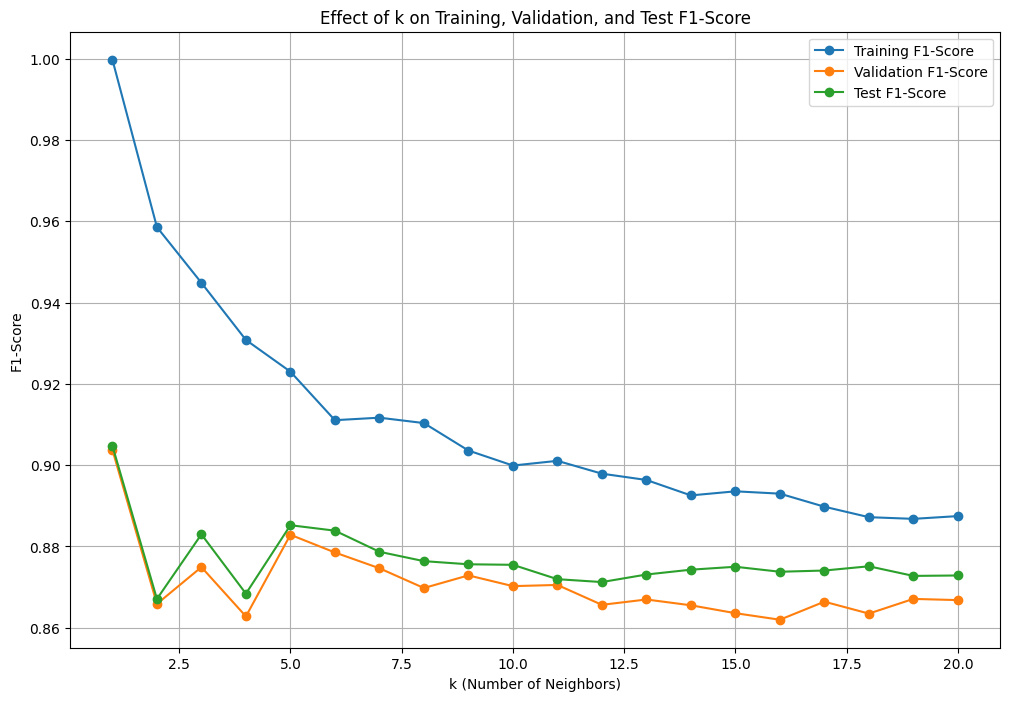

In [ ]:


# Load data
data = np.load("pca_reduced_data_90.npz")
X_train, y_train = data["train_pca"], data["train_labels"]
X_val, y_val = data["val_pca"], data["val_labels"]
X_test, y_test = data["test_pca"], data["test_labels"]

# Preprocess data
#X_train_scaled, X_val_scaled, X_test_scaled = preprocess_data(X_train, X_val, X_test)

# Initialize lists to store metrics
k_values = range(1, 21)
train_metrics = {"accuracy": [], "precision": [], "recall": [], "f1": []}
val_metrics = {"accuracy": [], "precision": [], "recall": [], "f1": []}
test_metrics = {"accuracy": [], "precision": [], "recall": [], "f1": []}

# Iterate over k values
for k in k_values:
    knn = KNN(k=k, device="cuda")

    # Fit the model
    knn.fit(X_train, y_train)

    # Evaluate on training data
    train_accuracy = knn.evaluate(X_train, y_train)
    train_predictions = knn.predict(X_train)
    train_precision = precision_score(y_train, train_predictions.cpu(), average='binary')
    train_recall = recall_score(y_train, train_predictions.cpu(), average='binary')
    train_f1 = f1_score(y_train, train_predictions.cpu(), average='binary')

    # Store training metrics
    train_metrics["accuracy"].append(train_accuracy)
    train_metrics["precision"].append(train_precision)
    train_metrics["recall"].append(train_recall)
    train_metrics["f1"].append(train_f1)

    # Evaluate on validation data
    val_accuracy = knn.evaluate(X_val, y_val)
    val_predictions = knn.predict(X_val)
    val_precision = precision_score(y_val, val_predictions.cpu(), average='binary')
    val_recall = recall_score(y_val, val_predictions.cpu(), average='binary')
    val_f1 = f1_score(y_val, val_predictions.cpu(), average='binary')

    # Store validation metrics
    val_metrics["accuracy"].append(val_accuracy)
    val_metrics["precision"].append(val_precision)
    val_metrics["recall"].append(val_recall)
    val_metrics["f1"].append(val_f1)

    # Evaluate on test data
    test_accuracy = knn.evaluate(X_test, y_test)
    test_predictions = knn.predict(X_test)
    test_precision = precision_score(y_test, test_predictions.cpu(), average='binary')
    test_recall = recall_score(y_test, test_predictions.cpu(), average='binary')
    test_f1 = f1_score(y_test, test_predictions.cpu(), average='binary')

    # Store test metrics
    test_metrics["accuracy"].append(test_accuracy)
    test_metrics["precision"].append(test_precision)
    test_metrics["recall"].append(test_recall)
    test_metrics["f1"].append(test_f1)

    # Print current k results
    print("--------------------------------------------------")
    print(f"K = {k}")
    print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
    print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
    print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Plot Accuracy
plt.figure(figsize=(12, 8))
plt.plot(k_values, train_metrics["accuracy"], label="Training Accuracy", marker='o')
plt.plot(k_values, val_metrics["accuracy"], label="Validation Accuracy", marker='o')
plt.plot(k_values, test_metrics["accuracy"], label="Test Accuracy", marker='o')
plt.xlabel("k (Number of Neighbors)")
plt.ylabel("Accuracy")
plt.title("Effect of k on Training, Validation, and Test Accuracy")
plt.legend()
plt.grid()
plt.show()

# Plot Precision
plt.figure(figsize=(12, 8))
plt.plot(k_values, train_metrics["precision"], label="Training Precision", marker='o')
plt.plot(k_values, val_metrics["precision"], label="Validation Precision", marker='o')
plt.plot(k_values, test_metrics["precision"], label="Test Precision", marker='o')
plt.xlabel("k (Number of Neighbors)")
plt.ylabel("Precision")
plt.title("Effect of k on Training, Validation, and Test Precision")
plt.legend()
plt.grid()
plt.show()

# Plot Recall
plt.figure(figsize=(12, 8))
plt.plot(k_values, train_metrics["recall"], label="Training Recall", marker='o')
plt.plot(k_values, val_metrics["recall"], label="Validation Recall", marker='o')
plt.plot(k_values, test_metrics["recall"], label="Test Recall", marker='o')
plt.xlabel("k (Number of Neighbors)")
plt.ylabel("Recall")
plt.title("Effect of k on Training, Validation, and Test Recall")
plt.legend()
plt.grid()
plt.show()

# Plot F1-Score
plt.figure(figsize=(12, 8))
plt.plot(k_values, train_metrics["f1"], label="Training F1-Score", marker='o')
plt.plot(k_values, val_metrics["f1"], label="Validation F1-Score", marker='o')
plt.plot(k_values, test_metrics["f1"], label="Test F1-Score", marker='o')
plt.xlabel("k (Number of Neighbors)")
plt.ylabel("F1-Score")
plt.title("Effect of k on Training, Validation, and Test F1-Score")
plt.legend()
plt.grid()
plt.show()
